- Created: 2018-12-08
- Last modified: 2018-12-08
- Purpose: to compare existing network `refseq75` to string data base E.coli PPI

- Steps:
1. ran diamond blastp --query REPRESENTING-GENES-ECOLI --db STRING-DB-SEQUENCES
2. extract max `pident`, identity for each **STRING DB ID** (ex: 511145.b0002)
3. remove all matches with less than 70% pident; 70% becuase we built pan-genome based on 70% threshold
4. compare the links predicted by our net (refseq90) and STRING DB

- Results: very few overlap

- Interpretation
1. There might be some problems with our net
2. Our Net is trained based on GO-term sharing for functional prediction. Not all PPI has GO-term sharing (but expect many of them should have)

In [32]:
import pandas as pd
def read_node_to_df(fname):
    '''
    input: diamond blastp --query REPRESETING_GENE --db STRING.dmnd --outfmt 6
    output: dataframe with essential info
    '''
    node = pd.read_csv(fname, sep = '\t', header = None)
    node = node[[0,1,2,10]]
    node = node.rename(columns = {0:'qseqid', 1:'sseqid', 2:'pident', 10:'evalue'})
    return(node)


In [33]:
node_path = '/home/hermuba/data0118/cdhit/map_to_exist_net/ec70_string'
node = read_node_to_df(node_path)

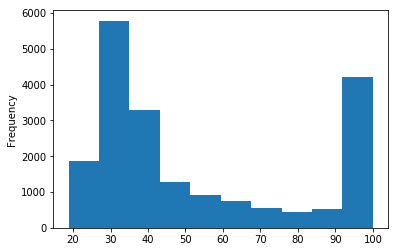

In [5]:
%matplotlib inline
node['pident'].plot(kind = 'hist')

In [35]:
# before filtering low pident
node.shape

(19626, 4)

In [8]:
node.head()

,qseqid,pident,evalue
sseqid,,,
511145.b0002,JMUY01000009_5|1438670.3,100.0,1.400000e-44
511145.b0003,JMUY01000009_6|1438670.3,99.4,2.400000e-181
511145.b0004,JMUY01000009_7|1438670.3,99.5,2.800000e-249
511145.b0005,FLWH01000009_163|562.12962,100.0,2.800000e-09
511145.b0006,JMUY01000009_9|1438670.3,98.8,1.000000e-145


In [38]:
def filter_node(node):
    '''
    input: node dataframe from `read_node_to_df
    output: filtered net
    steps:
    1. select max pident for each sseqid(STRING ID)
    2. remove all hits with pident < 70
    '''
    max_node = node.groupby(by = 'sseqid').max(level = 'pident')
    selected_nodes = max_node.loc[max_node['pident']>= 70]
    return(selected_nodes)

In [39]:
selected_nodes = filter_node(node)

In [40]:
selected_nodes.shape # selected nodes contain REPRESENTING GENE - STRING id converter

(4079, 3)

# Let's import all connections from STRING

In [41]:
def string_edge_to_df(fname):
    edge = pd.read_csv(fname, sep = ' ')
    return(edge)

In [42]:
edge_path = '/home/hermuba/data0118/cdhit/map_to_exist_net/511145.protein.links.v10.5.txt'
edge = string_edge_to_df(edge_path)

In [13]:
edge.head()

,protein1,protein2,combined_score
0,511145.b0001,511145.b0075,379
1,511145.b0001,511145.b2018,519
2,511145.b0001,511145.b0273,202
3,511145.b0001,511145.b2011,214
4,511145.b0001,511145.b3863,167


In [44]:
edge.shape # has a lot of duplicates

(1166880, 3)

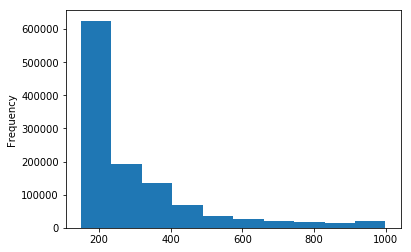

In [87]:
edge.combined_score.plot(kind = 'hist')

# Mapping STRING ID to REPRESENTING GENE ID

In [50]:
def map_string_to_repr(edge, selected_nodes):
    '''
    input: edge and node from `read_edge/node_to_df` and subsepquent processing
    output: edge table with additional columns gene_one, gene_two; representing gene ids
    '''
    edge['gene_one'] = edge['protein1'].map(selected_nodes['qseqid'])
    edge['gene_two'] = edge['protein2'].map(selected_nodes['qseqid'])
    
    edge.dropna(how = 'any', inplace = True) # we do not need interaction between genes that does not exist in our net
    edge.to_csv('/home/hermuba/data0118/goldstandard/EC70_string_edges')
    return(edge)

In [51]:
selected_edge = map_string_to_repr(edge, selected_nodes)

In [45]:
edge.shape

(1166880, 3)

In [49]:
selected_edge.shape

(1159522, 5)

In [52]:
selected_edge.head()

,protein1,protein2,combined_score,gene_one,gene_two
26,511145.b0002,511145.b3397,449,JMUY01000009_5|1438670.3,FLXF01000003_90|562.12961
27,511145.b0002,511145.b1338,453,JMUY01000009_5|1438670.3,JMVB01000033_111|1438673.3
28,511145.b0002,511145.b1686,214,JMUY01000009_5|1438670.3,JMUY01000001_885|1438670.3
29,511145.b0002,511145.b1341,167,JMUY01000009_5|1438670.3,NIPT01000031_7|562.17733
30,511145.b0002,511145.b0060,180,JMUY01000009_5|1438670.3,FLWH01000007_157|562.12962


# INPUT our net `eskape` and `refseq`

In [55]:
def our_net_to_df(fname):
    our_net = pd.read_csv(fname, sep = ',', header = 0)
    return(our_net)

In [56]:
# merge with refseq90
refseq_path = '/home/hermuba/data0118/network1122/refseq_mu_high_75.csv'
eskape_path = '/home/hermuba/data0118/network1122/eskape_mu_high.csv'
refseq = our_net_to_df(refseq_path)
eskape = our_net_to_df(eskape_path)

In [57]:
refseq.head()

,mutual_info,nrm_mutual,gene_one,gene_two,goldstandard
0,0.419584,0.787639,562.23304.con.0006_192|562.23304,562.22658.con.0002_220|562.22658,NaN
1,0.391253,0.773301,562.23304.con.0006_192|562.23304,562.22909.con.0002_319|562.22909,NaN
2,0.074130,0.919936,562.22859.con.0026_36|562.22859,562.22697.con.0023_36|562.22697,NaN
3,0.409849,0.815928,562.23304.con.0006_192|562.23304,562.23416.con.0004_246|562.23416,NaN
4,0.077508,0.871718,562.22859.con.0026_36|562.22859,562.22859.con.0026_30|562.22859,NaN


In [58]:
refseq.shape #significantly less than string

(113811, 5)

In [59]:
eskape.shape # not to say this one

(51286, 5)

# compare interaction between `our net` and `STRING`

In [82]:
def compare_net(our_net, string):
    
    our_links = [frozenset(x) for x in our_net[['gene_one', 'gene_two']].values]
    string_links = [frozenset(x) for x in string[['gene_one', 'gene_two']].values]
    
    print(type(our_links))
    ours = set(our_links)
    strs = set(string_links)
    
    
    return(len(ours.intersection(strs)), ours, strs)

In [83]:
common, ours, strs = compare_net(refseq, selected_edge)

<class 'list'>


In [84]:
common #refseq hits 13968/1460960

13968

In [85]:
len(strs)

460960

In [86]:
len(ours) # 1/10 is supported by STRING

113811

In [ ]:
def generate_cytoscape(strs, ours)
    all_pairs = strs.union(ours)
    all_pairs
    df = pd.DataFrame()